# Machine learning I

files needed = ('auto.csv')

In the next few classes, we will introduce some ideas from 'machine learning.' Machine learning sounds really complicated, but the good news is that, as trained econometricians, you already know a lot of machine learning. 

Our goals here are modest. We would like to
1. learn a bit about how machine learning is similar to, and different from, econometrics.  
2. introduce the scikit-learn package which is chock full of 'machine learning' tools. 
3. work on some *validation* methods, which are an important part of the machine learning toolkit. 

This notebook is loosely based on Chapters 2 and 5 from *An Introduction to Statistical Learning* by James, Witten, Hastie, and Tibshirani. This is an easy to follow introduction that is light on the mathematics behind the methods.   

### Inference v. prediction

Suppose we have data on a variable of interest $y$ and variables we think are important for determining $y$, $x_1, x_2,...x_p$. We assume that $y$ is related to the $x$ variables according to 

$$y = f(X)+\epsilon$$

where $X$ is the matrix of $x$ variables. The $f()$ function represents the *systematic* or *structural* relationship between $y$ and $X$ and $\epsilon$ is the *noise* or *error term*.

An important part of both machine learning and econometrics is estimating $f()$. Why we care about $f()$ is where machine learning and econometrics often (but not always) diverges. 

* Machine learning often prioritizes **prediction**: The estimate of $f()$ is important in that it is useful for out-of-sample prediction. Can I predict the value of the S&P 500 index tomorrow? 
* Econometrics often prioritizes **inference**: The estimate of $f()$ is important in that it tells us about how $y$ and $X$ are related. How is the S&P 500 value related to interest rates? Inference is often associated with some kind of theoretical model in mind that lays out relationships between the $y$ and $X$ variables. The estimate of $f()$ helps us quantify and better understand these models. 

### Specifying f( )

How do we know which variables to include in $X$, or what is $f(\; )$? In econometrics, we use a model to guide our choice of $f()$. This reflects econometrics' goal of inference. 

What if we are interested only in prediction? Shouldn't we just throw everything into $f(\; )$ and see what happens? Shouldn't more data be better than less data? Shouldn't more flexibility in specifying $f(\;)$ be better than less flexibility? 

Perhaps surprisingly, the answer is 'no.' An important problem when inference is not a concern in the that of *overfitting* the data. Overfitting occurs when our estimate of $f(\;)$ captures too much of the noise, $\epsilon$.  The noise has nothing to do with the structural relationship $f(\;)$, which will make our estimate $f(\;)$ a bad predictor. 

An important part of the machine learning (prediction) approach is validating the model in respect to its ability to predict. This is a bit different than the approach we learned in econometrics, and we will dig into it in a minute... 


### Predicting with OLS

Let's start with predicting a variable using ols as our method. This means that $f(\;)$ is a linear function of $X$. As econometricians, we know a lot about ols. 

We first need to figure out how to perform ols in scikit-learn.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load data on automobile fuel efficiency. The data are available [here](http://www-bcf.usc.edu/~gareth/ISL/Auto.data). I have already converted the data into a csv file. Load it into a DataFrame.

In [24]:
# There are a few missing values coded as '?'. 
auto = pd.read_csv('auto.csv', na_values='?')

In [25]:
# What do we have?
print(auto.head())
print('\n\n')
print(auto.info())


    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
mpg             397 non-null float64
cylinders       397 non-null int64
displacement    397 non-null float64
horsepower      392 non-null float64
weight          397 non-null int64
acceleration    397 n

It looks like we are missing a few observations on horsepower. Drop them.  

In [26]:
auto = auto.dropna()

### Linear regression in scikit learn

For machine learning in python, scikit is the standard. It contains both the methods to estimate $f(\;)$ and the methods to validate the models. Linear regression is the starting point for estimating $f(\; )$. 

Here is how it works in scikit learn [(docs)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).  

In [28]:
# If you are running anaconda, this should already be installed. If not
# pip install --user scikit-learn

# From scikit-learn, peel off the linear_model package
from sklearn import linear_model 

Scikit-learn is a bit clunkier than statsmodels. In statsmodels we had a nice way to specify the regression model with a string. In scikit-learn, we directly pass the data to the `.fit()` method. 

In [29]:
res = linear_model.LinearRegression().fit(auto[['horsepower', 'weight']], auto['mpg'])

Let's break this down. 

1. The code `linear_model.LinearRegression()` creates a model object.
2. The code `.fit(auto[['horsepower', 'weight']], auto['mpg'])` estimates a linear object where y=mpg and X = [horsepower, weight]. Notice that we pass X, then y: `.fit(X_vars, y_var)`. As in statsmodels, we get the **constant for free**. 
3. Like in statsmodels, the fit method of the linear regression model returns a results object. 

In [32]:
# Try a tab complete. What looks good?
res

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
print('The coefficients except the intercept:', res.coef_, '\n')
print('The intercept:', res.intercept_)

The coefficients except the intercept: [-0.04730286 -0.00579416] 

The intercept: 45.64021084017712


### Set validation approach

Suppose we would like to predict the mpg of a car given its characteristics. Which characteristics should we include? 

We would like to include characteristics that make the model good for prediction. Here is one way to go.

1. We break our dataset up into two subsets. Call one the *training set* and the other the *testing set*. 
2. We estimate our model on the training data. We measure how well our model fits the data by looking at the mean squared error of the regression or, alternatively, the r-squared, which normalizes the mse by the total squared error. We call these the **training mse or the training $r^2$**. This is usually what we care about when we are doing inference. 
3. Using the X data in the testing data, we use the estimated $f(\;)$ from step 2 to predict value for y
$$\hat{y} = \hat{f}(X_{test}).$$
4. We then compare the predicted ($\hat{y}$) values with the actual ($y$) values in the training data. Again, we can use mse or r-squared to judge how well our predicted data matched the actual data. Call this the **test mse or test $r^2$**. This is what we usually care about when we are interested in prediction. 

An important conceptual point is that **improving the training mse does not always improve the test mse**. This is the overfitting problem. By making the model more flexible and adding more variables to $X$ we can improve the training mse (a lot). The problem is that we will start to capture more and more of the $\epsilon$ values in our estimate of $f( )$, which will make it a worse estimate of the true $f(\;)$. 

Note that using the test mse/r-squared to validate the model is a general idea. We are currently thinking about ols models of $f(\;)$ but this approach (and modifications of it) are applicable to many different approaches to estimating $f(\;)$.

More on this later. For now, the point is that we need to pay attention to the test mse. How do we implement the algorithm above? 

#### Step 1:
First, we need to break the data up into two sets. We could do it manually (slicing!) but it is better if we let python do it for us. From scikit-learn we import some tools to do it.  

In [34]:
from sklearn.model_selection import train_test_split

Pass the function the data you want in your regression and it passes back two datasets [(docs)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

If we do nothing with the `random_state` parameter, the function will split the data into two randomly assigned groups. If we assign a random state, then we will always get the same division of the dataset. This way we all get the same answer. 

We can specify how large to make the test and train samples, too. If we do not, then 25 percent of the observations are assigned to the test and 75 percent to the train. 

In [35]:
rs = 33  # Set the random state. This ensures that we have the same answers.

X_train, X_test, y_train, y_test = train_test_split(auto[['horsepower', 'weight']], auto['mpg'], random_state = rs)

In [13]:
print(type(X_train))
print('The training dataset has {0} entries and the testing dataset has {1} entries.'.format(len(X_train), len(X_test)) )

<class 'pandas.core.frame.DataFrame'>
The training dataset has 294 entries and the testing dataset has 98 entries.


#### Step 2:
Now we estimate (fit) the model using the training data. 

In [36]:
res_train_1 = linear_model.LinearRegression().fit(X_train, y_train)

In [43]:
print('The coefficients except the intercept:', res_train_1.coef_, '\n')
print('The intercept:', res_train_1.intercept_)
print('The training r-square is:', res_train_1.score(X_train, y_train))

The coefficients except the intercept: [-0.03953282 -0.00618264] 

The intercept: 45.82346434983981
The training r-square is: 0.7196501714044371


#### Steps 3 & 4: 
We next predict using the testing data, and find the training $r^2$.

scikit learn wraps this up in one command. From the results object, we find the `.score()` method. Pass it the testing data and it passes back the training $r^2$. 

In [38]:
r2_1 = res_train_1.score(X_test, y_test)
print(r2_1)

0.6565709109674498


For this **specific split of the data**, the training r-squared is less than the testing r-squared. 

Let's do that again, but using a different randomly determined split. 

In [48]:
rs = 50   # A different random sample

# step 1: break up the data
X_train, X_test, y_train, y_test = train_test_split(auto[['horsepower', 'weight']], auto['mpg'], random_state = rs)

# step 2: train the model
res_train_2 = ols.fit(X_train, y_train)
print('The estimated coefficients except the intercept:', res_train_2.coef_)
print('The intercept:', res_train_2.intercept_)
print('The training r-square is {0:.3}'.format( res_train_2.score(X_train, y_train)))

# steps 3 & 4: predict and score 
r2_2 = res_train_2.score(X_test, y_test)
print('The testing r-squared is {0:.3}'.format(r2_2))

The estimated coefficients except the intercept: [-0.0601157  -0.00544075]
The intercept: 46.147254276480695
The training r-square is 0.691
The testing r-squared is 0.742


In this case, the testing r-squared is greater than the training r-squared. 

As the sample changes, so do the metrics of fit. This suggests that repeatedly estimating and validating the sample on randomly assigned testing and training sets will help average out this variation. 

## Practice

Let's use set validation to decide if adding a quadratic horsepower term increases the fit on the test data. We will perform 20 estimations & validations of each model, and compare the average test r2s. 

Of course, we will not write the estimation/validation out 40 times! We can wrap our computation up in a user-defined function, and then put the whole thing in a loop. 

1. Write a function named 'set_val' that takes the X data, the y data and a value for the random state as parameters. Inside the function, split the data into test and training sets using the random state it was passed. Estimate the model on the training data, and return the `.score( )` using the testing data.  

2. Test your function with the call
```python
set_val(auto[['horsepower', 'weight']], auto['mpg'], 33)
```

The answer should be 0.656570...as it is above. 


In [18]:
def set_val(X, y, ran_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = ran_state)
    res = ols.fit(X_train, y_train)
    return res.score(X_test, y_test)
    

In [19]:
set_val(auto[['horsepower', 'weight']], auto['mpg'], 33)

0.6565709109674498

3. Call `set_val(auto[['horsepower', 'weight']], auto['mpg'], rs)` 20 times, passing a new value for rs each time (I would use a for loop). The random state values are in the list below. Save the $r^2$ score for each evaluation in a list named `lin_res`.  

```python
rss = [10, 2, 5, 3, 1000, 9, 38, 61, 999, 1, 25, 13, 48, 97, 11, 65, 88, 46, 55, 17]
```

In [64]:
lin_res = []
rss = [10, 2, 5, 3, 1000, 9, 38, 61, 999, 1, 25, 13, 48, 97, 11, 65, 88, 46, 55, 17]
for i in rss:
    r2 = set_val(auto[['horsepower', 'weight']], auto['mpg'], i)
    lin_res.append(r2)

Check: Is `lin_res` filled with 10 numbers? 

In [65]:
len(lin_res)

20

Now let's do the same thing again, but add a quadratic horsepower term. 

4. Create a new column in the auto DataFrame that holds the squared value of 'horsepower.' Do not loop over the rows of the DataFrame to do so.  

In [67]:
auto['hp2'] = auto['horsepower']**2

5. As you did in part 3., estimate and validate the model 10 times, using the same `rss` vector for the random states. The call to `set_val` now looks like: `set_val(auto[['horsepower', 'weight', 'hp2']], auto['mpg'], rs)`. Save the $r^2$ score for each evaluation in a list named `quad_res`.  

In [71]:
quad_res = []
rss = [10, 2, 5, 3, 1000, 9, 38, 61, 999, 1, 25, 13, 48, 97, 11, 65, 88, 46, 55, 17]
for i in rss:
    r2 = set_val(auto[['horsepower', 'weight', 'hp2']], auto['mpg'], i)
    quad_res.append(r2)

6A. Compute the means of `lin_res` and `quad_res`. Does the model with the quadratic horsepower term perform better or worse than the model with only a linear horsepower term? 

6B. Compute the standard deviation of `lin_res` and `quad_res`.

In [77]:
print('The mean score for the linear hp model is {0:.3} and the mean score for the quandratic hp model is {1:.3}.'
      .format( np.mean(lin_res), np.mean(quad_res)) )
print('The mean score for the linear hp model is {0:.3} and the mean score for the quandratic hp model is {1:.3}.'
      .format( np.std(lin_res), np.std(quad_res)) )

The mean score for the linear hp model is 0.704 and the mean score for the quandratic hp model is 0.735.
The mean score for the linear hp model is 0.0437 and the mean score for the quandratic hp model is 0.0488.


7. Plot two histograms in the same figure (so use two axes objects). In one plot the histogram of the r-squared for the model with only a linear horsepower term. In the second plot the histogram of the r-squared for the model with both the linear and quadratic terms.  

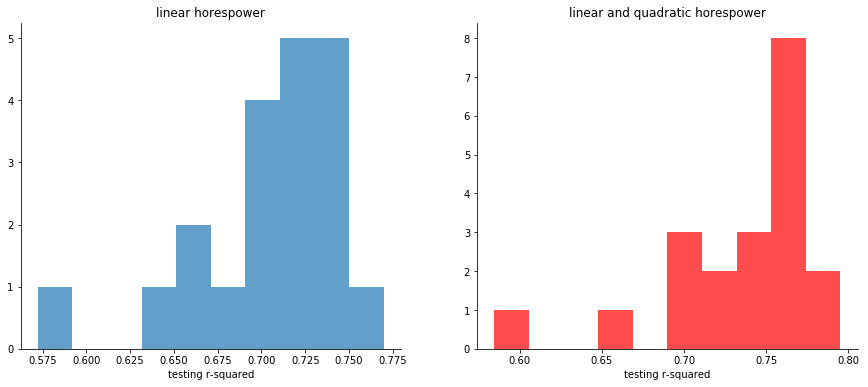

In [73]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].hist(lin_res, alpha=0.7)
ax[1].hist(quad_res, color='red', alpha = 0.7)

ax[0].set_xlabel('testing r-squared')
ax[1].set_xlabel('testing r-squared')

ax[0].set_title('linear horespower')
ax[1].set_title('linear and quadratic horespower')

sns.despine(ax = ax[0])
sns.despine(ax = ax[1])

plt.show()

Our approach looks like it is converging to a central tendency, but there is certainly some variation. We will move on to more sophisticated methods next. 